In [4]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet

In [2]:
filename = 'Daily Bike Sharing.csv'
path = '..\Dataset'
filepath = os.path.join(path,filename)

In [6]:
df = pd.read_csv(filepath)

In [7]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
df = df.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
df.head(1) 

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


In [10]:
df.dteday= pd.to_datetime(df.dteday,format="%Y-%m-%d")

In [11]:
df.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [12]:
df = df.rename(columns = {'cnt' : 'y'})
df = df.rename(columns = {'dteday' : 'ds'})
df.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


<AxesSubplot: >

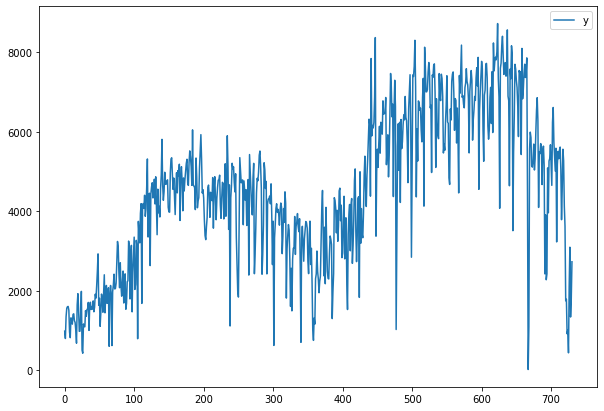

In [14]:
df['y'].plot(figsize=(10,7),legend = True)

In [18]:
holiday_dates = df[df.holiday == 1].ds
holidays = pd.DataFrame({'holiday': 'holi',
                        'ds':pd.to_datetime(holiday_dates),
                        'lower_window':-3,
                        'upper_window':1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [19]:
df = df.drop(columns='holiday')
df.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


In [21]:
#Training and test set
test_days = 31
training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


In [22]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

17:28:43 - cmdstanpy - INFO - Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [27]:
#merge regressors
future = pd.concat([future, df.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [28]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1718.548938,102.377029,1861.828273,1718.548938,1718.548938,-0.042322,-0.042322,-0.042322,-0.307105,...,0.000000,0.000000,0.000000,-0.268446,-0.268446,-0.268446,0.0,0.0,0.0,984.751100
1,2011-01-02,1728.048731,-69.885422,1704.003158,1728.048731,1728.048731,-0.045884,-0.045884,-0.045884,-0.312059,...,0.000000,0.000000,0.000000,-0.260693,-0.260693,-0.260693,0.0,0.0,0.0,810.106756
2,2011-01-03,1737.548525,133.314402,1906.538620,1737.548525,1737.548525,-0.105096,-0.105096,-0.105096,-0.081572,...,0.155464,0.155464,0.155464,-0.251617,-0.251617,-0.251617,0.0,0.0,0.0,1049.316034
3,2011-01-04,1747.048318,235.944437,2060.498474,1747.048318,1747.048318,-0.096911,-0.096911,-0.096911,-0.074029,...,0.155464,0.155464,0.155464,-0.241339,-0.241339,-0.241339,0.0,0.0,0.0,1136.164009
4,2011-01-05,1756.548111,307.110769,2145.983392,1756.548111,1756.548111,-0.090732,-0.090732,-0.090732,0.000326,...,0.155464,0.155464,0.155464,-0.230003,-0.230003,-0.230003,0.0,0.0,0.0,1280.704083


In [29]:
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

700    4186.665426
701    3537.050856
702    5735.307322
703    5736.968957
704    5442.590695
Name: prophet, dtype: float64

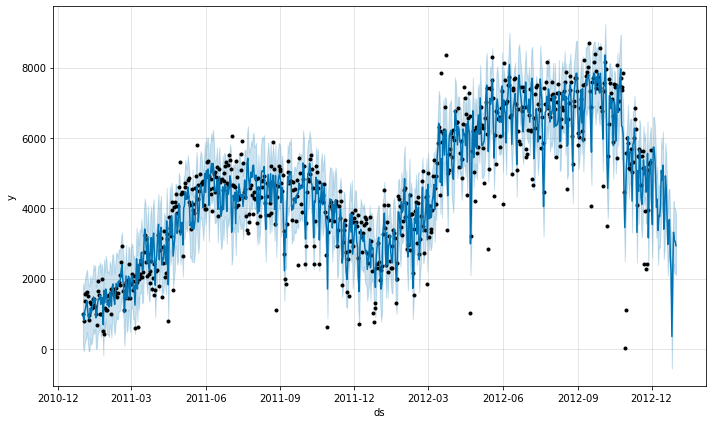

In [30]:
#visualization forecast
m.plot(forecast);

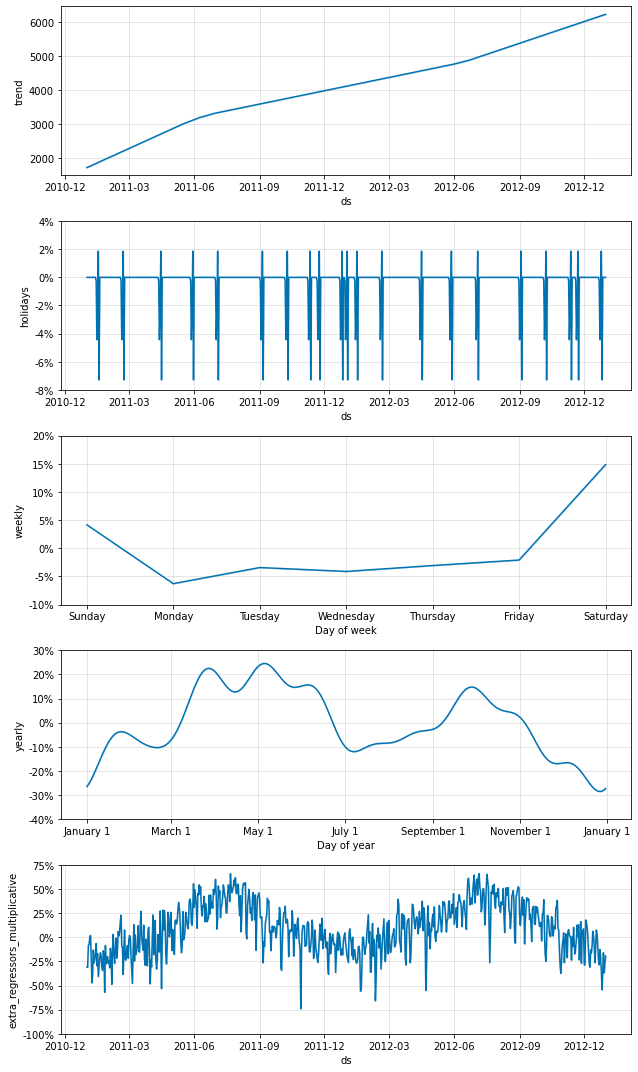

In [31]:
#plot components
m.plot_components(forecast);

In [32]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

846.0
1019.0


In [33]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

34.44161776441973